In [11]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt

In [12]:
in1 = cv.VideoCapture('../data/2024-10-25_1848.mp4')

In [13]:
readIn,frame = in1.read()

In [14]:
if not readIn or frame is None:
    raise ValueError("Could not read video. Check the file path or video format.")
print(frame.shape)

(1024, 1024, 3)


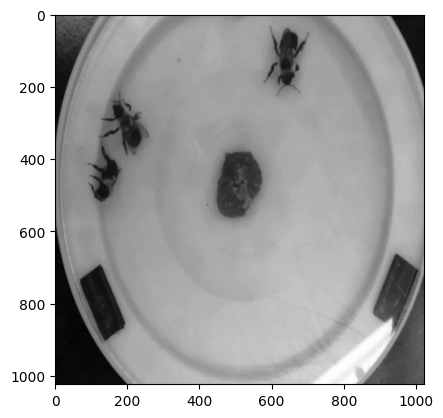

In [15]:
temp = cv.cvtColor(frame,cv.COLOR_BGRA2GRAY)
plt.imshow(temp,cmap=plt.cm.Grays_r)

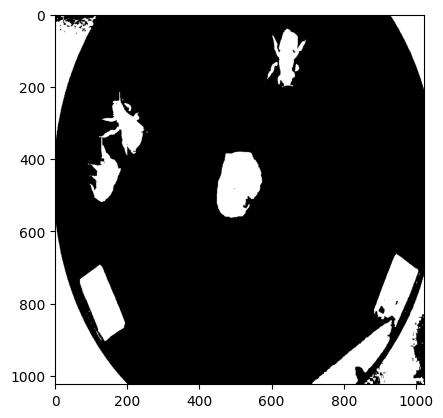

In [16]:
tempIm = cv.cvtColor(frame,cv.COLOR_BGR2GRAY) >75
tempIm2 = cv.cvtColor(frame,cv.COLOR_BGR2GRAY) < 200
tempIm = tempIm*tempIm2
binaryThreshold = (tempIm).astype(np.uint8)
plt.imshow(binaryThreshold,cmap=plt.cm.Grays)

In [17]:

MIN_BEE_AREA = 1500  
MAX_BEE_AREA = 4000  

in1 = cv.VideoCapture('../data/2024-10-25_1848.mp4')
allTail = []

telemetry_file = open("../outputs/bee_telemetry.csv", "w")
telemetry_file.write("frame,bee_id,x,y\n")

momx = []
momy = []

cpx = 0
cpy = 0

readIn,frame = in1.read()

for ebt in range(0,300):
    
    readIn,frame = in1.read()
    if not readIn:
        break
    f2 = frame.copy()
    kernel = np.ones((20, 20), np.uint8)

    tempIm = cv.cvtColor(frame,cv.COLOR_BGR2GRAY) >75
    tempIm2 = cv.cvtColor(frame,cv.COLOR_BGR2GRAY) < 200
    tempIm = tempIm*tempIm2

    binaryThreshold = (tempIm).astype(np.uint8)
    dilated_mask = cv.dilate(binaryThreshold, kernel, iterations=1)

    contours, _ = cv.findContours(dilated_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    flycnt = 0

    newFrame = []
    nt = []
    for contour in contours:
        if cv.contourArea(contour) > MAX_BEE_AREA or cv.contourArea(contour) < MIN_BEE_AREA:
            continue
        
        x, y, w, h = cv.boundingRect(contour)
        cv.rectangle(f2, (x, y), (x + w, y + h), (0, 255, 0), 6)
        
        center_x = x + (w / 2)
        center_y = y + (h / 2)
        nt.append((center_x, center_y))
        
        telemetry_file.write(f"{ebt},{flycnt},{center_x},{center_y}\n")
        flycnt += 1
    
    if len(allTail)>1:
        xdisp = []
        ydisp = []
        for ntt in nt:
            fmin = []
            for ele in allTail[0]:
                fmin.append(np.linalg.norm(np.array(ele)-ntt))
            if not fmin: continue
            indd = np.argmin(fmin)
            if not nt: continue
            xdisp.append(allTail[0][indd][0]-nt[0][0])
            ydisp.append(allTail[0][indd][1]-nt[0][1])
        if xdisp:
            fx = np.nanmean(xdisp)
            fy = np.nanmean(ydisp)
            cpx+=fx
            cpy+=fy
            momx.append(cpx)
            momy.append(cpy)
            plt.figure(figsize=(6,6),dpi=200)
            plt.plot(momx,momy,linewidth=2)
            plt.scatter(momx[-1],momy[-1],s=50)
            plt.xlim([-30000,30000])
            plt.ylim([-30000,30000])
            plt.savefig('../outputs/test_plot_%03d.jpg' % ebt)
            plt.close()
            
    allTail.append(nt)
    if len(allTail) > 25:
        allTail.pop(0)
    
    for ind,eee in enumerate(allTail[::-1]):
        for ind2,ee in enumerate(eee):
            tail_l = 17-(ind)
            if tail_l <=5: tail_l = 5
            cv.circle(f2,(int(ee[0]),int(ee[1])),tail_l,color=(200,100,100),thickness=-1)
            
    cv.imwrite('../outputs/test_frame_%03d.jpg' % ebt, f2)

telemetry_file.close()

In [18]:
import glob
import cv2 as cv # It's good practice to have the import here too

# This line finds ALL files inside your 'beet' folder.
# The '*' is a wildcard. Make sure this path is correct!
ims = glob.glob('../outputs/test_frame_*')
ims.sort() # This is very important to keep the frames in order!

# This line sets up the video file you are about to create.
# Make sure this path points to where you want to save the final video.
vidOut = cv.VideoWriter('../outputs/bt2.mp4', cv.VideoWriter_fourcc(*'mp4v'), 15, (1024,1024))

# This loop reads each image and writes it to the video file.
for ele in ims:
  in2 = cv.imread(ele)
  vidOut.write(in2)
  
vidOut.release()
print("Video creation complete!") # Added a print statement for confirmation

Video creation complete!


In [19]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

FPS = 15.0
TIME_PER_FRAME = 1.0 / FPS  # this is the time (in sec) between each frame

DISH_DIAMETER_METERS = 0.1  # diameter of the dish is likely 10cm (0.1m)
DISH_DIAMETER_PIXELS = 920.0
PIXELS_PER_METER = DISH_DIAMETER_PIXELS / DISH_DIAMETER_METERS

# load the telemetric data
try:
    df = pd.read_csv('../outputs/bee_telemetry.csv')
    print("Successfully loaded")
except FileNotFoundError:
    print("Error")

# tracking
tracked_data = []
next_bee_id = 0
last_frame_tracks = {}  # this is a dictionary to hold {tracked_id: (x, y)} for the last frame

# group and process data by frames
for frame_num, group in df.groupby('frame'):
    current_frame_positions = group[['x', 'y']].to_numpy()
    
    if not last_frame_tracks:
        for i, pos in enumerate(current_frame_positions):
            last_frame_tracks[next_bee_id] = pos
            tracked_data.append({'frame': frame_num, 'tracked_id': next_bee_id, 'x': pos[0], 'y': pos[1], 'speed_mps': 0})
            next_bee_id += 1
        continue

    last_ids = list(last_frame_tracks.keys())
    last_pos = np.array(list(last_frame_tracks.values()))
    
    # distance matrix calculation: rows are current bees and columns are last frame's bees
    distances = cdist(current_frame_positions, last_pos)
    
    current_tracks = {}
    matched_last_ids = set()
    
    for i, pos in enumerate(current_frame_positions):
        # find the closest bee from the last frame
        dist_row = distances[i, :]
        
        #  the following avoids reusing a bee from the last frame
        dist_row[[idx for idx, last_id in enumerate(last_ids) if last_id in matched_last_ids]] = np.inf

        if np.all(np.isinf(dist_row)): continue # No available bees to match
            
        best_match_idx = np.argmin(dist_row)
        tracked_id = last_ids[best_match_idx]
        
        # speed calculation (m/s)
        prev_pos = last_frame_tracks[tracked_id]
        dist_pixels = np.linalg.norm(pos - prev_pos)
        dist_meters = dist_pixels / PIXELS_PER_METER
        speed_mps = dist_meters / TIME_PER_FRAME
        
        # append the data to the correct tracked_id
        tracked_data.append({'frame': frame_num, 'tracked_id': tracked_id, 'x': pos[0], 'y': pos[1], 'speed_mps': speed_mps})
        current_tracks[tracked_id] = pos
        matched_last_ids.add(tracked_id)
        
    last_frame_tracks = current_tracks

# print the data in the console
if tracked_data:
    df_tracked = pd.DataFrame(tracked_data)
    df_tracked.to_csv('../outputs/bee_telemetry_with_speed.csv', index=False)
    print("Successfully saved tracked data to bee_telemetry_with_speed.csv")
    
    # displays the first 5 frames of data as a sample
    print("\nsample:")
    print(df_tracked.head())

    print("\nAverage speed per bee (m/s):")
    print(df_tracked.groupby('tracked_id')['speed_mps'].mean())

Successfully loaded
Successfully saved tracked data to bee_telemetry_with_speed.csv

sample:
   frame  tracked_id      x      y  speed_mps
0      0           0  142.5  458.0   0.000000
1      0           1  201.0  309.0   0.000000
2      0           2  647.0  122.0   0.000000
3      1           0  142.0  454.5   0.005764
4      1           1  200.5  304.5   0.007382

Average speed per bee (m/s):
tracked_id
0    0.002176
1    0.067741
2    0.028130
Name: speed_mps, dtype: float64


In [20]:
import pandas as pd
import openpyxl

# constants
# 0.01m/s is what i use for the maximum 'idling' speed, since the bees that are idling are likely moving very slowly
IDLE_SPEED_THRESHOLD_MPS = 0.01 

OUTPUT_EXCEL_FILE = '../outputs/bee_summary_statistics.xlsx'

# loading the data
try:
    df_tracked = pd.read_csv('../outputs/bee_telemetry_with_speed.csv')
    print("Successfully loaded the tracked data.")
except FileNotFoundError:
    print(f"did not find '{'bee_telemetry_with_speed.csv'}'.")

# calculates and shows the summary statistics
if 'df_tracked' in locals():
    # get the basic stats (mean, max, count)
    bee_stats = df_tracked.groupby('tracked_id')['speed_mps'].agg(['mean', 'max', 'count']).rename(
        columns={'mean': 'Average Speed (m/s)', 'max': 'Max Speed (m/s)', 'count': 'Frames Tracked'}
    )
    
    # calculate idling time
    # count how many frames each bee's speed was below the 'idling' threshold
    idle_frames = df_tracked[df_tracked['speed_mps'] < IDLE_SPEED_THRESHOLD_MPS].groupby('tracked_id').size()
    
    # this adds the 'Idle Frames' count to the table
    bee_stats['Idle Frames'] = idle_frames.reindex(bee_stats.index, fill_value=0)
    
    # this calculates the percent of time spent idling (idle frames / total frames)*(100)
    bee_stats['Idle Percentage (%)'] = (bee_stats['Idle Frames'] / bee_stats['Frames Tracked'] * 100).round(2)
    
    # export the data to excel as bee_summary_statistics.xlsx
    try:
        bee_stats.to_excel(OUTPUT_EXCEL_FILE)
        print(f"export completed and saved as: {OUTPUT_EXCEL_FILE}")
        print("------------------------------------------------------------------------")
    except Exception as e:
        print(f"\nthere is a save error: {e}")

    print("\nFinal Data Table:")
    print(bee_stats)

Successfully loaded the tracked data.
export completed and saved as: ../outputs/bee_summary_statistics.xlsx
------------------------------------------------------------------------

Final Data Table:
            Average Speed (m/s)  Max Speed (m/s)  Frames Tracked  Idle Frames  \
tracked_id                                                                      
0                      0.002176         0.005764              35           35   
1                      0.067741         1.228802             300          142   
2                      0.028130         0.883589             137           61   

            Idle Percentage (%)  
tracked_id                       
0                        100.00  
1                         47.33  
2                         44.53  
